In [1]:
import pandas as pd

# Data Import

In [2]:
df=pd.read_csv("/content/df_pca_n.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,close
0,-4.728898,-1.115874,-0.350434,0.465851,0.346966,-0.063788,-0.840479,-0.644939,0.120015,1.910322,1.305534,0.669070,0.307071,1.389222,1.563639,0.564337,0.155247,28212.73
1,-4.635488,-2.741018,1.690103,-2.328273,-0.770616,1.601905,0.038216,-1.187851,1.623920,0.795812,-1.426525,1.030457,0.065907,1.300028,1.824407,-0.132587,0.037102,28127.82
2,-4.694583,-1.193204,0.440777,1.554080,0.044771,0.620009,0.986779,0.868953,1.621704,-0.432284,0.463382,0.740617,0.691632,1.340005,1.675177,0.299795,0.201588,28169.00
3,-4.708888,-2.340780,0.054083,-0.864007,0.050861,-0.809183,-2.061673,0.437444,1.108165,0.823587,0.540933,0.793279,0.287486,1.366688,1.618464,0.438763,0.133583,28128.59
4,-4.715028,-1.494159,0.141522,1.021576,0.024130,0.061481,0.593962,-0.776617,1.957156,0.502589,1.086233,0.736398,0.540106,1.357617,1.638440,0.410520,0.196583,28150.00


In [3]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

# WGAN Model

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

#### Sliding Window

In [5]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

tmp_x = [0,1,2,3,4]

tmp_y = [5]

tmy_y_gan = [0,1,2,3,4,5]

#### HyperParameters

In [6]:
sliding_window_size = 10
testing_duration = 2016
training_duration = 2016

#### Train Test Split

In [7]:
labels_df = df["close"]
features_df = df.drop(columns=["close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (2016, 17) trainY: (2016,)
testX: (2016, 17) testY: (2016,)


In [8]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [9]:
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (2016, 17) trainY: (2016, 1)
testX: (2016, 17) testY: (2016, 1)


In [10]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([2006, 10, 17]) train_y: torch.Size([2006, 1]) train_y_gan: torch.Size([2006, 11, 1])
test_x: torch.Size([2006, 10, 17]) test_y: torch.Size([2006, 1]) test_y_gan: torch.Size([2006, 11, 1])


## Model Implementation

In [11]:

import math, torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x



class TemporalFusionTransformerGenerator(nn.Module):
    """A lightweight Temporal Fusion Transformer generator for WGAN."""
    def __init__(self, input_size, hidden_size=256, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        self.pos_enc = PositionalEncoding(hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=n_heads,
            dim_feedforward=hidden_size*4,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, hidden_size//4)
        self.out = nn.Linear(hidden_size//4, 1)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        # Use representation of final time step
        x = x[:, -1, :]
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        return self.out(x)


In [12]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 3 1D Conv layers
    self.conv1 = nn.Conv1d(sliding_window_size+1, 32, kernel_size = 5, stride = 1, padding = 'same')
    self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
    self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')

    # 3 linear layers
    self.linear1 = nn.Linear(128, 220)
    self.linear2 = nn.Linear(220, 220)
    self.linear3 = nn.Linear(220, 1)

    self.leaky = nn.LeakyReLU(0.01)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    conv1 = self.conv1(x)
    conv1 = self.leaky(conv1)
    conv2 = self.conv2(conv1)
    conv2 = self.leaky(conv2)
    conv3 = self.conv3(conv2)
    conv3 = self.leaky(conv3)

    flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])

    out_1 = self.linear1(flatten_x)
    out_1 = self.leaky(out_1)
    out_2 = self.linear2(out_1)
    out_2 = self.relu(out_2)
    out_3 = self.linear3(out_2)

    return out_3

In [13]:
def grad_penalty_fnc(real_data, gen_data,D,cuda,gp_weight):
    batch_size = real_data.size()[0]
    t = torch.rand((batch_size, 1, 1), requires_grad=True)
    t = t.expand_as(real_data)

    if cuda:
        t = t.cuda()

    # mixed sample from real and fake; make approx of the 'true' gradient norm
    interpol = t * real_data.data + (1-t) * gen_data.data

    if cuda:
        interpol = interpol.cuda()
    prob_interpol = D(interpol)
    torch.autograd.set_detect_anomaly(True)
    gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                           grad_outputs=torch.ones(prob_interpol.size()).cuda() if cuda else torch.ones(
                               prob_interpol.size()), create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    #grad_norm = torch.norm(gradients, dim=1).mean()
    #self.losses['gradient_norm'].append(grad_norm.item())

    # add epsilon for stability
    eps = 1e-10
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
    #gradients = gradients.cpu()
    # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
    final = gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()
    return final


In [14]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cuda


In [15]:
batch_size = 128
learning_rate = 0.000115
num_epochs = 1000
critic_iterations = 5

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

# Give number of features to the G
modelG = TemporalFusionTransformerGenerator(train_x.shape[1]).to(device)
modelD = Discriminator().to(device)

#weight_decay-L2 penalty to the weights
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

# optimizerG = torch.optim.RMSprop(modelG.parameters(), lr = learning_rate, weight_decay = 1e-3)
# optimizerD = torch.optim.RMSprop(modelD.parameters(), lr = learning_rate, weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

#k=0
i=0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        i=1
        fake_data = torch.cat([y[:, :sliding_window_size, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        for _ in range(critic_iterations):
            critic_real = modelD(y)
            critic_fake = modelD(fake_data)
            grad_penalty, grad_norm_ = grad_penalty_fnc(y, fake_data,modelD,cuda,10)
            # Take probability mean of whole batch.
            lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + grad_penalty

            modelD.zero_grad()
            lossD.backward(retain_graph = True)
            optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)

        modelG.zero_grad() # zeroing the gradients
        lossG.backward() # computing the gradients
        optimizerG.step() # updating the parameters

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())

    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[1/1000] LossD: -0.011664770543575287 LossG:0.5793216228485107
[2/1000] LossD: -0.0005686432123184204 LossG:0.4448277447372675
[3/1000] LossD: -0.003977417945861816 LossG:0.2977352049201727
[4/1000] LossD: -0.005174474325031042 LossG:0.16740088816732168
[5/1000] LossD: -0.006880743079818785 LossG:0.05497502058278769
[6/1000] LossD: -0.014619231544202194 LossG:0.025310189899755642
[7/1000] LossD: -0.058405545616551535 LossG:0.017510414283606224
[8/1000] LossD: -0.38817685935646296 LossG:0.04971650172956288
[9/1000] LossD: -1.3951938065184208 LossG:0.18280131369829178
[10/1000] LossD: -1.5214009739927166 LossG:-0.6100662872195244
[11/1000] LossD: -1.4494754797951495 LossG:-0.7485553780570626
[12/1000] LossD: -1.4546781545325083 LossG:-1.2966603692620993
[13/1000] LossD: -1.5297195342268042 LossG:-1.1382437478750944
[14/1000] LossD: -1.498464717884762 LossG:-1.4297934798523784
[15/1000] LossD: -1.3880217568213487 LossG:-1.0711834043031558
[16/1000] LossD: -1.3804899299923954 LossG:-1.1237

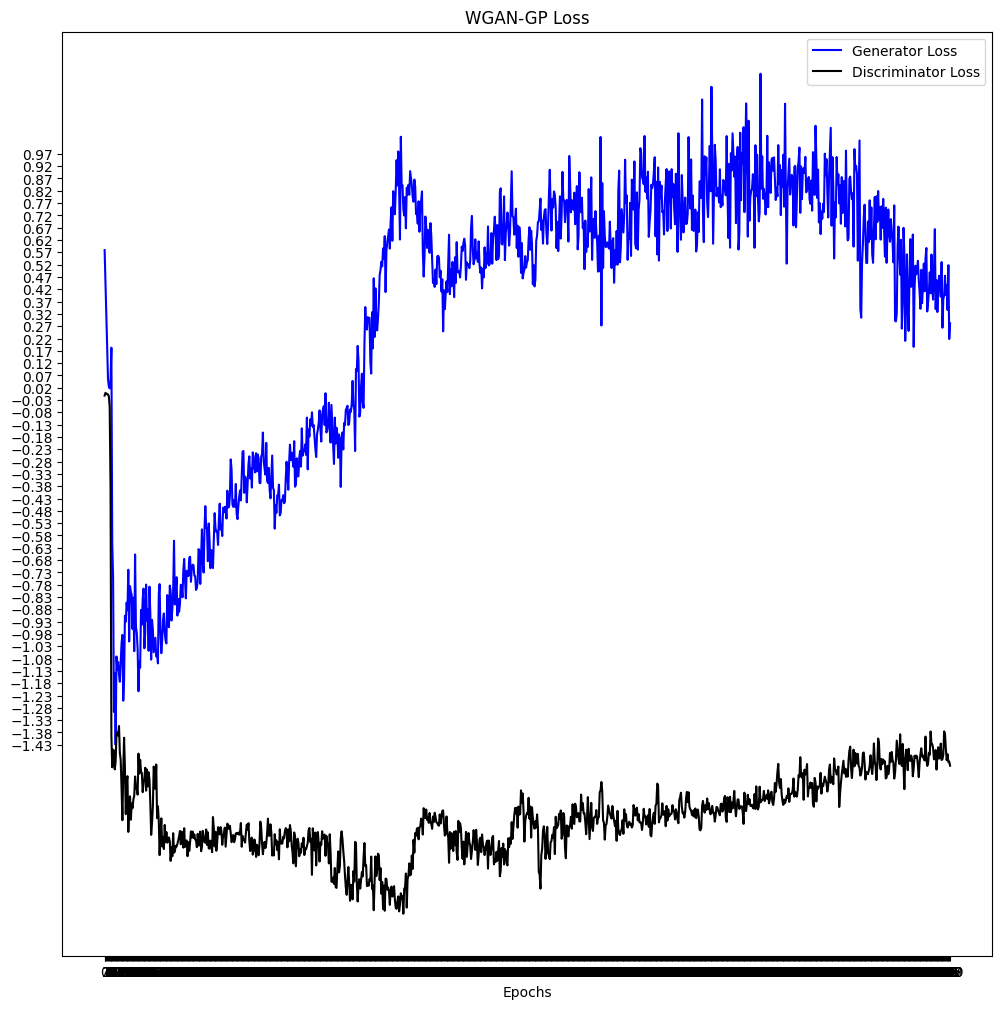

In [16]:
plt.figure(figsize = (12, 12))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.xticks(np.arange(0, num_epochs, 1.0))
plt.yticks(np.arange(min(histG), 1, 0.05))
plt.title('WGAN-GP Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [17]:
train_y_slide.shape

torch.Size([2006, 1])

In [18]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:416.49253844817025


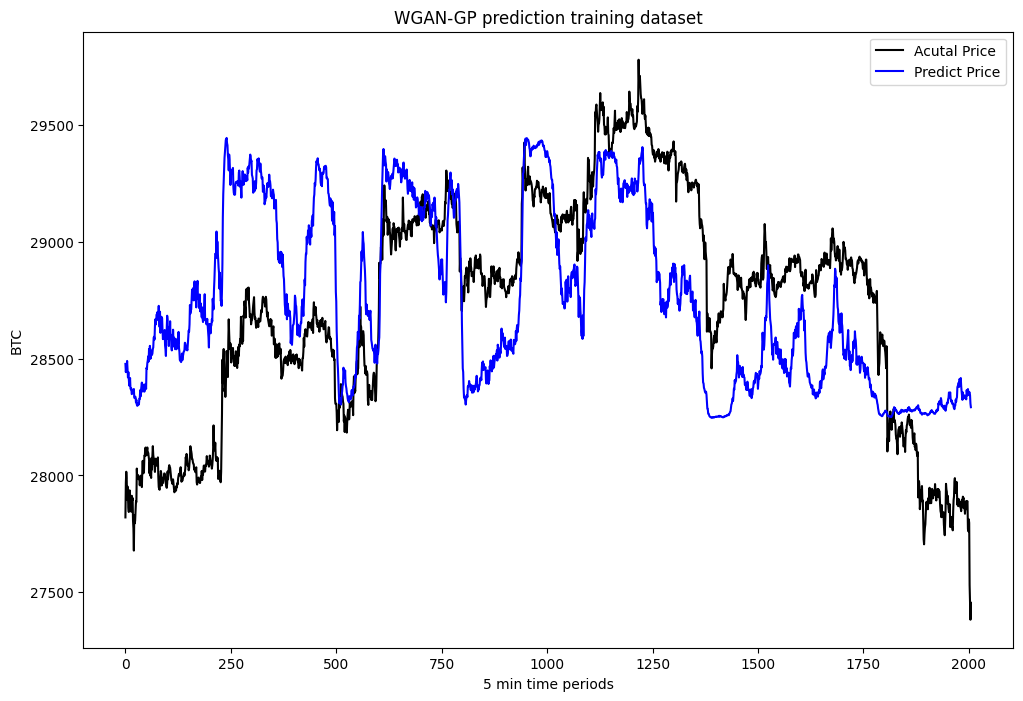

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:1187.6865901865795


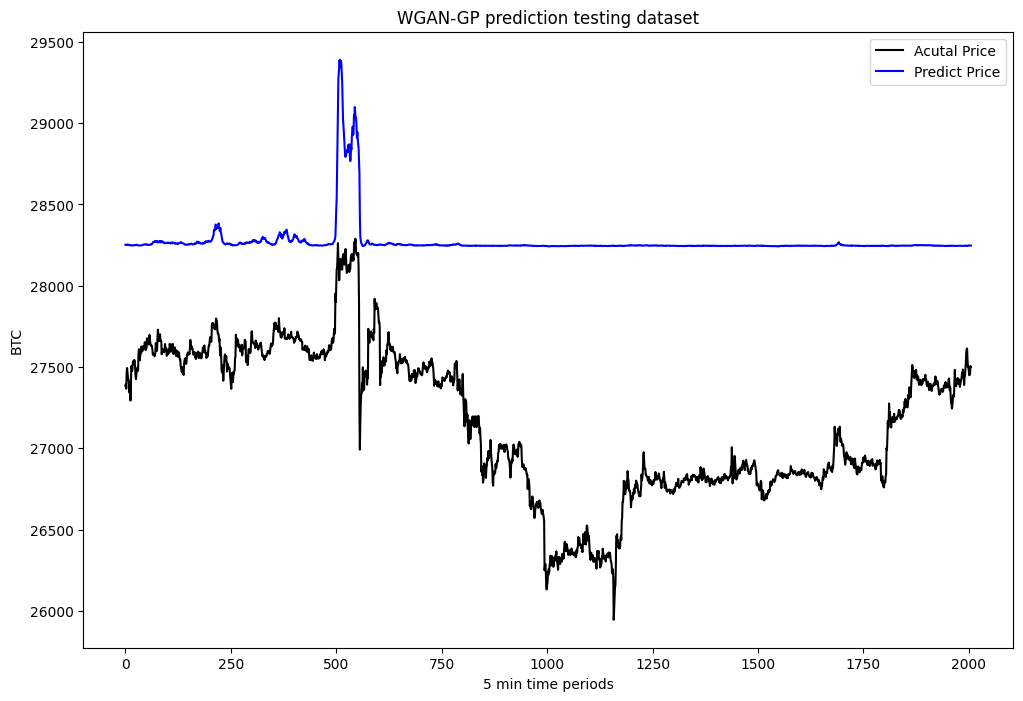

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')